<center><font size = 8><b>Machine Learning Project Phase I</b></font></center><br/><br/>
<center><font size = 6><b>Covid-19 Outcome Prediction</b></font></center>

### Name: Ahmed Mohammed Bakr Ahmed
### ID: 2000037
### Email: ahmedbakr2501@gmail.com

First import all libraries we will need.

In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

Load the dataset.

In [52]:
# Load the dataset
dataset = pd.read_csv('data.csv', index_col=0)

x = dataset.iloc[:, 0:13]
y = dataset.iloc[:, 13]

# Print first 5 rows of the dataset
dataset.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


Split and Scale the dataset for training, validation and testing.

In [53]:
# Split the dataset into training, validation and test
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)



Declare no. of folds.

In [54]:
N_FOLDS = 5

## KNN
### Get optimal hyperparameters for the KNN algorithm

In [55]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_neighbors': range(1, 15),
    'metric': ['euclidean']
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=N_FOLDS, scoring='f1')
grid_search_knn.fit(x_train, y_train)

# Create and train the K-Nearest Neighbors model
knn_classifier = grid_search_knn.best_estimator_

# Print the parameters of the classifier
print(knn_classifier.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


Predict y values and get report and roc_auc scores for training.

In [56]:
# Predict and print reports
y_val_pred_knn = knn_classifier.predict(x_val)
y_val_proba_knn = knn_classifier.predict_proba(x_val)[:, 1]

print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred_knn))
print("Validation ROC/AUC Score:", roc_auc_score(y_val, y_val_proba_knn))



Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       148
           1       0.92      0.44      0.59        25

    accuracy                           0.91       173
   macro avg       0.91      0.72      0.77       173
weighted avg       0.91      0.91      0.90       173

Validation ROC/AUC Score: 0.950135135135135


Plot ROC Curve

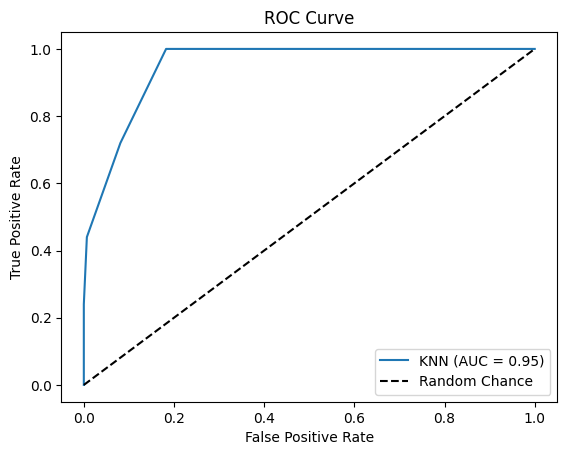

In [57]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_knn)
plt.figure()
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_score(y_val, y_val_proba_knn):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

Evaluate test results

In [58]:
# Evaluate the model on the test set
y_test_pred_knn = knn_classifier.predict(x_test)
y_test_proba_knn = knn_classifier.predict_proba(x_test)[:, 1]

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_knn))
print("Test ROC/AUC Score:", roc_auc_score(y_test, y_test_proba_knn))
print("Test Precision score:", precision_score(y_test, y_test_pred_knn))
print("Test f1 score:", f1_score(y_test,y_test_pred_knn))
print("Test recall score:", recall_score(y_test, y_test_pred_knn))


Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       150
           1       1.00      0.52      0.69        23

    accuracy                           0.94       173
   macro avg       0.97      0.76      0.83       173
weighted avg       0.94      0.94      0.93       173

Test ROC/AUC Score: 0.8815942028985507
Test Precision score: 1.0
Test f1 score: 0.6857142857142857
Test recall score: 0.5217391304347826


Plot Confusion Matrix

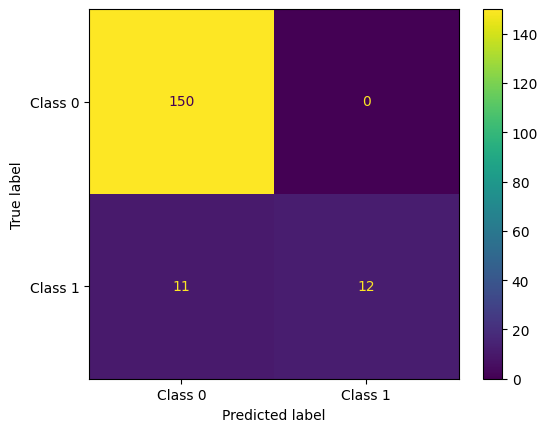

In [59]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, x_test, y_test, display_labels=['Class 0', 'Class 1'])
plt.show()

## Logistic Regression
Get optimal hyperparameters

In [60]:
# Hyperparameter tuning with GridSearchCV
param_grid = [
    {'C': [0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['saga']},  # L1 regularization
    {'C': [0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['saga']},  # L2 regularization
    {'C': [0.1, 1, 10, 100], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.9]}  # ElasticNet
]


grid_search = GridSearchCV(
    LogisticRegression(max_iter=5000),
    param_grid, cv=N_FOLDS,
    scoring='f1',
    error_score='raise'
)

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Create and train the K-Nearest Neighbors model
logistic_regression_classifier = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


Validate the model and print results

In [61]:
# Predict and print reports
y_val_pred_LR = logistic_regression_classifier.predict(x_val)
y_val_proba_LR = logistic_regression_classifier.predict_proba(x_val)[:, 1]


print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred_LR))
print("Validation ROC/AUC Score:", roc_auc_score(y_val, y_val_proba_LR))


Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       148
           1       0.75      0.72      0.73        25

    accuracy                           0.92       173
   macro avg       0.85      0.84      0.85       173
weighted avg       0.92      0.92      0.92       173

Validation ROC/AUC Score: 0.9764864864864865


Plot ROC Curve 

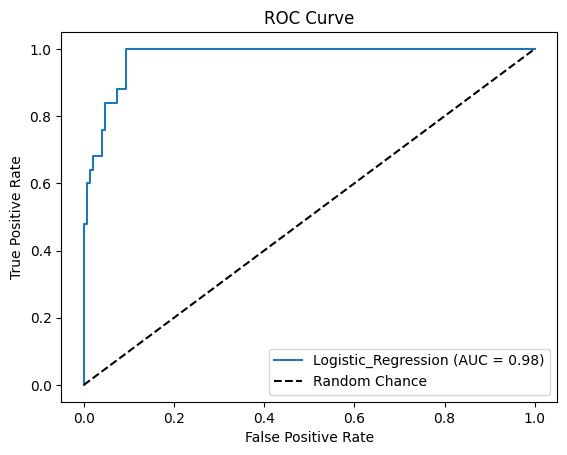

In [62]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_LR)
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic_Regression (AUC = {roc_auc_score(y_val, y_val_proba_LR):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')


Evaluate the model on test data and print the results

In [66]:
# Evaluate the model on the test set
y_test_pred_LR = logistic_regression_classifier.predict(x_test)
y_test_proba_LR = logistic_regression_classifier.predict_proba(x_test)[:, 1]

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_LR))
print("Test ROC/AUC Score:", roc_auc_score(y_test, y_test_proba_LR))
print("Test Precision score:", precision_score(y_test, y_test_pred_LR))
print("Test f1 score:", f1_score(y_test,y_test_pred_LR))
print("Test recall score:", recall_score(y_test, y_test_pred_LR))


Test Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       150
           1       0.93      0.61      0.74        23

    accuracy                           0.94       173
   macro avg       0.94      0.80      0.85       173
weighted avg       0.94      0.94      0.94       173

Test ROC/AUC Score: 0.9533333333333334
Test Precision score: 0.9333333333333333
Test f1 score: 0.7368421052631579
Test recall score: 0.6086956521739131


Plot Confusion Matrix

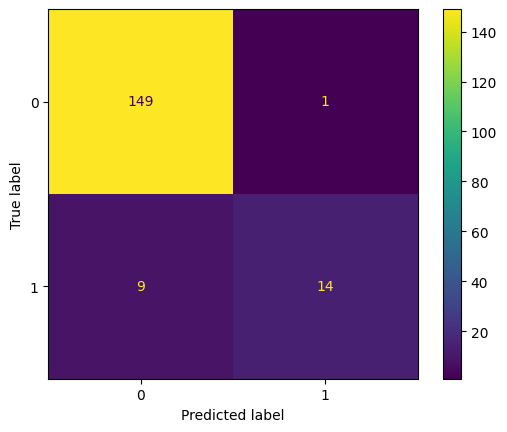

In [41]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(logistic_regression_classifier, x_test, y_test)
plt.show()

## Naive Bayes Classifier
First Train the Bayes Classifier

In [46]:
# Train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(x_train, y_train)


GaussianNB()

Predict and Print Reports

In [47]:
# Predict and print reports
y_val_pred_nb = nb_classifier.predict(x_val)
y_val_proba_nb = nb_classifier.predict_proba(x_val)[:, 1]

print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred_nb))
print("Validation ROC/AUC Score:", roc_auc_score(y_val, y_val_proba_nb))



Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       148
           1       0.15      1.00      0.25        25

    accuracy                           0.15       173
   macro avg       0.57      0.50      0.13       173
weighted avg       0.88      0.15      0.05       173

Validation ROC/AUC Score: 0.8775675675675676


Plot ROC Curve

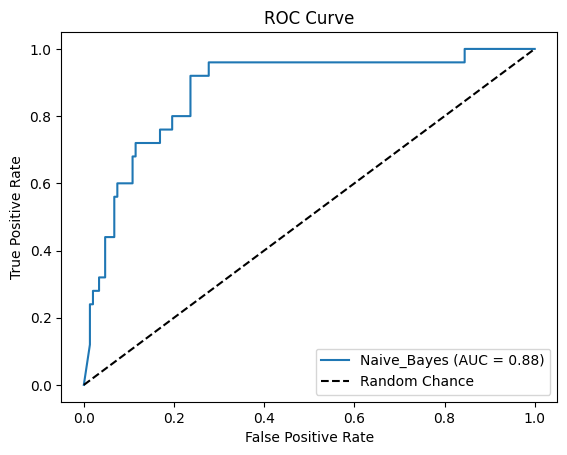

In [48]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_nb)
plt.figure()
plt.plot(fpr, tpr, label=f'Naive_Bayes (AUC = {roc_auc_score(y_val, y_val_proba_nb):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

Evaluate on test data

In [68]:
# Evaluate the model on the test set
y_test_pred_nb = nb_classifier.predict(x_test)
y_test_proba_nb = nb_classifier.predict_proba(x_test)[:, 1]

print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_nb))
print("Test ROC/AUC Score:", roc_auc_score(y_test, y_test_proba_nb))
print("Test Precision score:", precision_score(y_test, y_test_pred_nb))
print("Test f1 score:", f1_score(y_test,y_test_pred_nb))
print("Test recall score:", recall_score(y_test, y_test_pred_nb))
print("\033[34m--------------------------------------------------------------------------------\033[0m")



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       150
           1       0.13      1.00      0.24        23

    accuracy                           0.14       173
   macro avg       0.57      0.50      0.12       173
weighted avg       0.88      0.14      0.04       173

Test ROC/AUC Score: 0.8631884057971015
Test Precision score: 0.13372093023255813
Test f1 score: 0.2358974358974359
Test recall score: 1.0
--------------------------------------------------------------------------------


Plot the confusion matrix

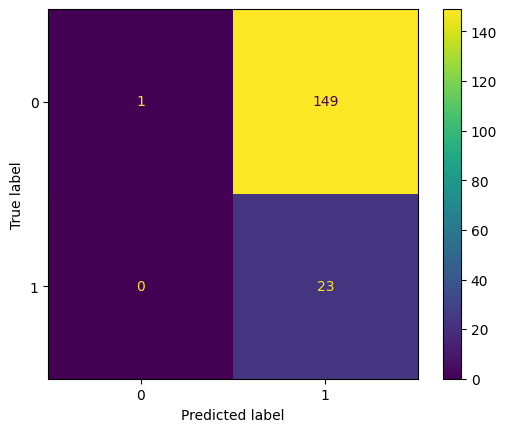

In [50]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(nb_classifier, x_test, y_test)
plt.show()

## Best Model Decision
Comparing the three models

|   | KNN | Logistic Regression | Naive Bayes |
| :--- | :--- | :--- | :--- |
| AUC | 0.95 | 0.98 | 0.88 |
| f1_score | 0.69 | 0.74 | 0.24 |
| Precision | 1.0 | 0.93 | 0.13 |
| Recall | 0.52 | 0.61 | 1.0 |

## Conclusion
Based on the AUC, f1_score, precision, and recall scores, the **Logistic Regression model** appears to be the most suitable for predicting the churn rate in this dataset. It has a high AUC score, indicating a good balance between true positives and false positives, and a high f1_score, precision, and recall score, indicating a good overall performance. The Naive Bayes model also performs well, but it has a lower AUC score.